# VGG16 기반 강아지 고양이 이미지 분류

## dogs-vs-cats 다운로드

In [ ]:
import gdown
gdown.download(id='18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd', output='dogs-vs-cats.zip')

Downloading...
From: https://drive.google.com/uc?id=18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd
To: /content/dogs-vs-cats.zip
100%|██████████| 852M/852M [00:17<00:00, 48.4MB/s]


'dogs-vs-cats.zip'

**압축 풀기**

In [ ]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

**기존 Train 폴더 (고양이,강아지 사진이 들어있다.)**

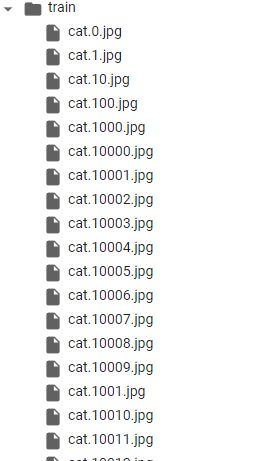

## Directory 배분

In [ ]:
import os, shutil, pathlib

# 기존 dir
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

# Directory 배분 함수
def make_subset(sub_dir, start_index, end_index):

    # 고양이, 강아지
    for category in ("cat", "dog"):

        # 새로운 Directory 이름
        dir = new_base_dir / sub_dir / category
        os.makedirs(dir)

        # 파일 가져오기
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

        # shutil.copyfile() 함수는 원본 파일을 대상 경로로 복사
        for fname in fnames:
            shutil.copyfile(src = original_dir / fname,
                            dst = dir / fname)


make_subset(sub_dir= "train", start_index=0, end_index=1000)
make_subset(sub_dir= "validation", start_index=1000, end_index=1500)
make_subset(sub_dir= "test", start_index=1500, end_index=2500)

**각 Train,Vaild,Test 폴더 분리 후 강아지,고양이 사진 분리**

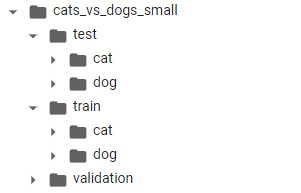

## Directory 이미지 불러오기

**image_dataset_from_directory()를 사용하여 Labeling 및 이미지 불러오기**

1. 이미지 Tensor로 변환

2. 각 폴더 별 다른 Label 부여

2. (이미지 Tensor, Label) 형태로 불러오기

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

# 이미지 Tensor로 변환
# 각 폴더별 다른 Label 부여 (/dogs, /cats 각 Label 부여)
# (이미지 Tensor, Label) 형태 Load
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**저장된 이미지 Shape 확인**

Target: tf.Tensor(1, shape=(), dtype=int32)


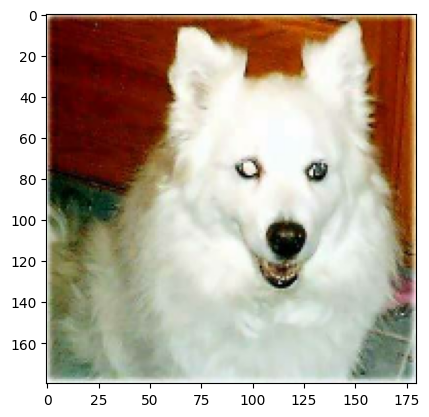

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img


for data_batch, labels_batch in train_dataset:
    plt.imshow(array_to_img(data_batch[0]))
    print("Target:", labels_batch[0])   # 고양이 = 0, 강아지 = 1
    break

## Conv_base 생성 (VGG16)

**keras.applications에서 사전에 ImageNet을 학습한 vgg16 네트워크 Conv_Base로 활용**

In [ ]:
from tensorflow import keras
from keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,    # Classifier 불러오기 False
    # input_shape = (180,180,3)
    )

## Fine_Tuning
**ConvBase 미세 조정 여부**

In [ ]:
# 마지막 4계층 weight 조정
for layer in conv_base.layers[-4:]:
    layer.trainable = False

## Classifier 생성

In [ ]:
from keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# 이미지_Size = (180, 180, 3)
inputs = keras.Input(shape=(180, 180, 3))

# *** 순서 중요 ***
x = data_augmentation(inputs)                     # 데이터_Augmentation
x = keras.applications.vgg16.preprocess_input(x)  # 이미지 전처리
x = conv_base(x)                                  # Conv_Base = vgg16

# Classifier
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# CNN 모델 생성
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0   

## 모델 학습

**Checkpoint과 EarlyStopping 기법 활용**

In [ ]:
callbacks = [

    # Check Point -> 최고 성능 모델 저장
    keras.callbacks.ModelCheckpoint(
        filepath="dogs_vs_cats_Transfer.keras",
        save_best_only=True,
        monitor="val_loss"),

     # Early Stopping -> 조기 종료
     keras.callbacks.EarlyStopping(
        monitor = "val_accuracy",
        patience = 15
    )
]

In [ ]:
model.compile(loss="binary_crossentropy",   # 2진 분류
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])


# 학습
history = model.fit(
    train_dataset,
    epochs=100,   # 100
    validation_data=validation_dataset,
    callbacks=callbacks)    # Callback

Epoch 1/100
63/63 [==============================] - 46s 408ms/step - loss: 2.7804 - accuracy: 0.6545 - val_loss: 0.5904 - val_accuracy: 0.8110
Epoch 2/100
63/63 [==============================] - 21s 323ms/step - loss: 0.7083 - accuracy: 0.7385 - val_loss: 0.2677 - val_accuracy: 0.8980
Epoch 3/100
63/63 [==============================] - 22s 338ms/step - loss: 0.4042 - accuracy: 0.8485 - val_loss: 0.2157 - val_accuracy: 0.9150
Epoch 4/100
63/63 [==============================] - 21s 321ms/step - loss: 0.3164 - accuracy: 0.8885 - val_loss: 0.2820 - val_accuracy: 0.9320
Epoch 5/100
63/63 [==============================] - 21s 331ms/step - loss: 0.2353 - accuracy: 0.9110 - val_loss: 0.1587 - val_accuracy: 0.9600
Epoch 6/100
63/63 [==============================] - 21s 326ms/step - loss: 0.2030 - accuracy: 0.9245 - val_loss: 0.1451 - val_accuracy: 0.9660
Epoch 7/100
63/63 [==============================] - 21s 326ms/step - loss: 0.1596 - accuracy: 0.9425 - val_loss: 0.1569 - val_accuracy:

**학습 그래프**

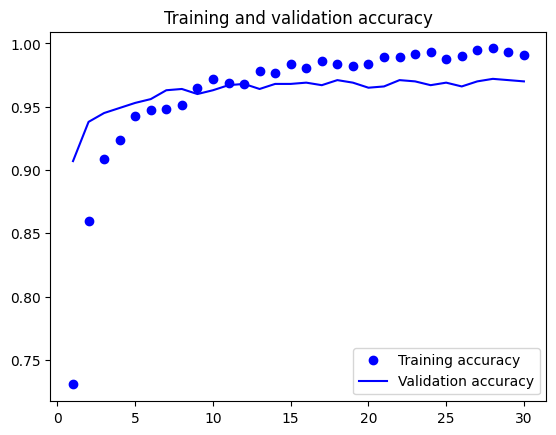

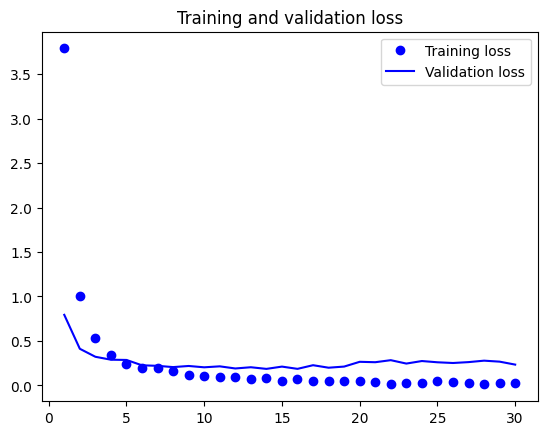

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## 성능 측정

In [ ]:
test_model = keras.models.load_model("dogs_vs_cats_Transfer.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 6s 91ms/step - loss: 0.1171 - accuracy: 0.9620
테스트 정확도: 0.962


## 새로운 이미지 예측

정답 Target: tf.Tensor(1, shape=(), dtype=int32)
1/1 [==============================] - 0s 24ms/step
강아지일 확률: [1.]


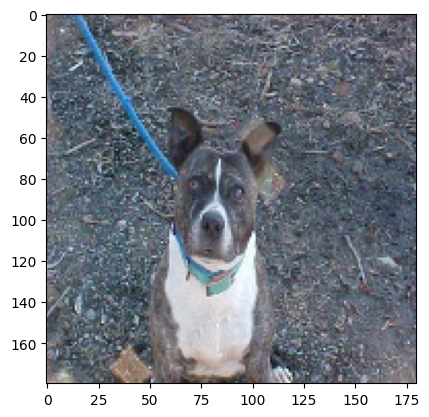

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img


for data_batch, labels_batch in test_dataset:
    plt.imshow(array_to_img(data_batch[0]))
    print("정답 Target:", labels_batch[0])   # 고양이 = 0, 강아지 = 1

    prediction = test_model.predict(data_batch)
    print("시그모이드 예측값:", prediction[0])   # 고양이 = 0, 강아지 = 1
    break